# Environment
- pandas
- pyarrow or fastparquet

```shell
![pip][conda][pipenv] install pandas pyarrow numpy
```

In [1]:
import pandas as pd
import numpy as np
idx = pd.IndexSlice

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.cluster import KMeans

In [2]:
positions_3d = "positions_3d.csv"
features = "features.parquet.gz"

In [3]:
#remove me!

# Positions

units: millimeters

In [4]:
positions_df = pd.read_csv(positions_3d, header=[0, 1], index_col=[0, 1, 2, 3]).astype(np.float16)

In [5]:
positions_df.head()

joint                              lear                 lelbow           \
variable                              x       y       z      x        y   
individual action   sample frame                                          
0          drinking 0      0      514.5 -355.50  2058.0  626.0  134.000   
                           1      515.0 -357.50  2060.0  626.0  134.000   
                           2      515.0 -357.50  2060.0  626.0  134.000   
                           3      515.0 -357.50  2060.0  626.0  134.000   
                           4      515.5 -359.75  2062.0  628.5  134.125   

joint                                       leye                 lshoulder  \
variable                               z       x       y       z         x   
individual action   sample frame                                             
0          drinking 0      0      1706.0  467.50 -369.00  2064.0     568.0   
                           1      1706.0  467.75 -371.00  2066.0     565.5   
                           2      1706.0  466.00 -373.25  2066.0     565.5   
                           3      1706.0  466.00 -373.25  2066.0     565.5   
                           4      1707.0  466.00 -373.25  2066.0     565.5   

joint                             ...  relbow    reye                  \
variable                          ...       z       x       y       z   
individual action   sample frame  ...                                   
0          drinking 0      0      ...  1678.0  366.50 -374.75  2070.0   
                           1      ...  1682.0  366.75 -377.00  2072.0   
                           2      ...  1682.0  366.75 -377.00  2072.0   
                           3      ...  1682.0  367.00 -379.25  2074.0   
                           4      ...  1682.0  367.00 -379.25  2074.0   

joint                            rshoulder                     rwrist          \
variable                                 x        y       z         x       y   
individual action   sample frame                                                
0          drinking 0      0       128.750 -72.9375  1891.0  42.84375  200.75   
                           1       128.875 -74.8750  1892.0  41.43750  200.00   
                           2       128.875 -74.8750  1892.0  41.43750  200.00   
                           3       128.875 -74.8750  1892.0  41.43750  200.00   
                           4       128.875 -74.8750  1892.0  41.43750  200.00   

joint                                     
variable                               z  
individual action   sample frame          
0          drinking 0      0      1469.0  
                           1      1473.0  
                           2      1473.0  
                           3      1473.0  
                           4      1473.0  

[5 rows x 33 columns]

In [6]:
positions_df.shape

(59941, 33)

In [7]:
positions_df.dtypes

joint      variable
lear       x           float16
           y           float16
           z           float16
lelbow     x           float16
           y           float16
           z           float16
leye       x           float16
           y           float16
           z           float16
lshoulder  x           float16
           y           float16
           z           float16
lwrist     x           float16
           y           float16
           z           float16
nose       x           float16
           y           float16
           z           float16
rear       x           float16
           y           float16
           z           float16
relbow     x           float16
           y           float16
           z           float16
reye       x           float16
           y           float16
           z           float16
rshoulder  x           float16
           y           float16
           z           float16
rwrist     x           float16
           y       

In [8]:
for i in range(positions_df.index.nlevels):
    index = positions_df.index.get_level_values(i).unique()
    print(index.name, ":", index, "\n")

individual : Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='individual') 

action : Index(['drinking', 'eat_crisp', 'open_close_bottle', 'rubiks_cube', 'sanitise',
       'touch_bottle', 'touch_rubiks_cube', 'transport_bottle',
       'transport_pen', 'transport_rubiks_cube'],
      dtype='object', name='action') 

sample : Int64Index([0, 1, 2], dtype='int64', name='sample') 

frame : Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            459, 460, 461, 462, 463, 464, 465, 466, 467, 468],
           dtype='int64', name='frame', length=469) 



In [9]:
for i in range(positions_df.columns.nlevels):
    col = positions_df.columns.get_level_values(i).unique()
    print(col.name, ":", col, "\n")

joint : Index(['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear',
       'relbow', 'reye', 'rshoulder', 'rwrist'],
      dtype='object', name='joint') 

variable : Index(['x', 'y', 'z'], dtype='object', name='variable') 



<AxesSubplot:>

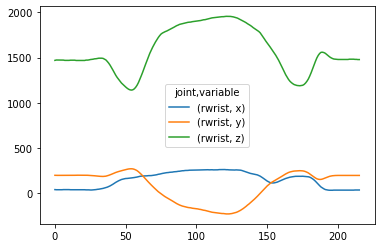

In [10]:
positions_df.loc[idx[0, "drinking", 0, :], idx["rwrist", :]].reset_index(drop=True).plot()

In [11]:
def plot_action(action, body, pearson):
    
    fig = plt.figure()
 
    # syntax for 3-D projection
    ax = plt.axes(projection ='3d')
    
    #rotazione di 180 rispetto a y e 180 rispetto a x
    ax.view_init(90,90)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    for i in range(0, len(body)):
        # defining all 3 axes
        z = positions_df.loc[idx[ pearson, action, 0, :], idx[body[i], "z"]]
        x = positions_df.loc[idx[ pearson, action, 0, :], idx[body[i], "x"]]
        y = positions_df.loc[idx[ pearson, action, 0, :], idx[body[i], "y"]]

        ax.plot3D(x, y, z)

    plt.show()
    


Di seguito i grafici che rappresentano l'azione di bere e di mangiare patatine, vediamo il comportamento dei due polsi e del naso per avere un riferimento con il viso, ci aspettiamo che i movimenti siano simili

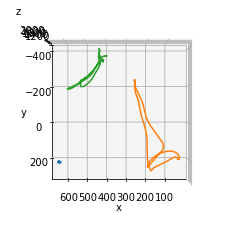

In [12]:
action = "drinking"
body = ["lwrist", "rwrist", "nose"]
plot_action(action,body,0)

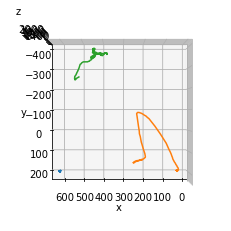

In [13]:
action = "eat_crisp"
plot_action(action,body,0)

I movimenti sono simili ma non del tutto, ci potrebbe essere una correlazione bassa, inoltre si nota che il polso sinistro rimane fermo in entrambi i casi, quindi lì la correlazione tra le due azioni è più alta

Di seguito i grafici che rappresentano l'azione di lavarsi le mani e di giocare con il cubo di rubik, vediamo il comportamento dei due polsi, gomiti e spalle e ci aspettiamo che i movimenti siano speculari tra i due polsi e simili tra le due azioni.

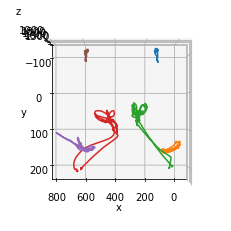

In [14]:
action = "sanitise"
body = ["rshoulder","relbow","rwrist", "lwrist", "lelbow", "lshoulder"]
plot_action(action,body,0)

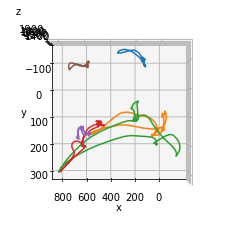

In [15]:
action = "rubiks_cube"
plot_action(action,body,0)

Le azioni non sono del tutto simili, probabilmente per la seconda azione c'è del rumore nato dal fatto che l'individuo ha preso il cubo dal tavolo e solo dopo ci ha giocato

Con molta probabilità i movimenti di tutte le componenti del viso per qualsiasi azione, saranno uguali ma con shift diversi, e anche i movimenti delle spalle perchè stanno sullo stesso asse, mentre i movimenti presi dai giunti delle braccia sono meno "rigidi"; per quanto riguarda le spalle abbiamo un esempio nei due grafici precedenti, vediamo che tracciano movimenti simili, ci potrebbe essere del rumore a causa di sovrapposizioni con altri nodi o perchè il nodo non è ben visibile dalla telecamera in quel momento. Di seguito, per alcuni movimenti, disegno i punti del viso:

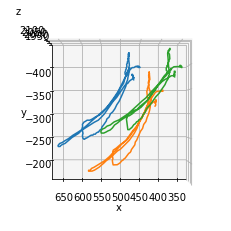

In [16]:
action = "drinking"
body = ["leye","nose","reye"] #problemi con l'orecchio sinistro
plot_action(action,body,0)

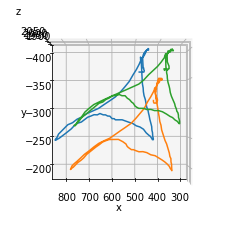

In [17]:
action = "transport_bottle"
#body = ["leye","nose","reye"] #problemi con l'orecchio sinistro
plot_action(action,body,0)

Ci aspettiamo una correlazione forte tra le varie azioni di trasporto.

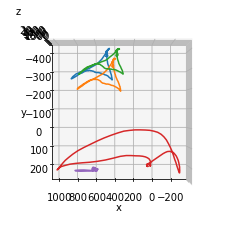

In [18]:
action = "transport_bottle"
body = ["leye","nose","reye","rwrist", "lwrist"]
plot_action(action,body,0)

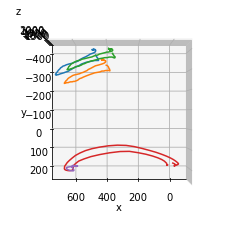

In [19]:
action = "transport_pen"
plot_action(action,body,0)

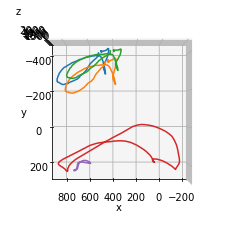

In [20]:
action = "transport_rubiks_cube"
plot_action(action,body,0)

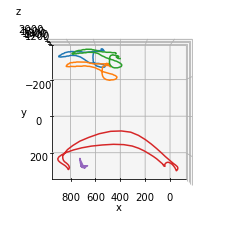

In [21]:
action = "transport_rubiks_cube"
plot_action(action,body,10)

# Features

units: meters and seconds

In [22]:
features_df = pd.read_parquet(features).applymap(lambda x: x.astype(np.float16))

In [23]:
features_df.head(1)

type_feature                                                       displacement  \
data                                                                  positions   
feature                                                        max_displacement   
variable                                                                      x   
joint person action   sample                                                      
lear  0      drinking 0       [0.015, 0.0205, 0.0285, 0.036, 0.044, 0.054, 0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      y   
joint person action   sample                                                      
lear  0      drinking 0       [0.02174, 0.02824, 0.03275, 0.03925, 0.04575, ...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      z   
joint person action   sample                                                      
lear  0      drinking 0       [0.014, 0.017, 0.019, 0.022, 0.024, 0.025, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                              magnitude   
joint person action   sample                                                      
lear  0      drinking 0       [0.0299, 0.03882, 0.0474, 0.05762, 0.0679, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                      total_displacement   
variable                                                                      x   
joint person action   sample                                                      
lear  0      drinking 0       [0.015, 0.02, 0.028, 0.0355, 0.043, 0.053, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      y   
joint person action   sample                                                      
lear  0      drinking 0       [0.01525, 0.02374, 0.02824, 0.03476, 0.0435, 0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      z   
joint person action   sample                                                      
lear  0      drinking 0       [-0.008, -0.013, -0.015, -0.018, -0.022, -0.02...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                              magnitude   
joint person action   sample                                                      
lear  0      drinking 0       [0.02284, 0.03366, 0.0425, 0.05283, 0.065, 0.0...   

type_fea

In [24]:
features_df.shape

(3520, 158)

In [25]:
features_df.dtypes

type_feature  data       feature             variable 
displacement  positions  max_displacement    x            object
                                             y            object
                                             z            object
                                             magnitude    object
                         total_displacement  x            object
                                                           ...  
dynamic       jerk       skewness            magnitude    object
                         kurtosis            x            object
                                             y            object
                                             z            object
                                             magnitude    object
Length: 158, dtype: object

In [26]:
type(features_df.iloc[0, 0])

numpy.ndarray

In [27]:
features_df.iloc[0, 0].dtype

dtype('float16')

In [28]:
for i in range(features_df.index.nlevels):
    print(features_df.index.get_level_values(i).unique())

Index(['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear',
       'relbow', 'reye', 'rshoulder', 'rwrist'],
      dtype='object', name='joint')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='person')
Index(['drinking', 'eat_crisp', 'open_close_bottle', 'rubiks_cube', 'sanitise',
       'touch_bottle', 'touch_rubiks_cube', 'transport_bottle',
       'transport_pen', 'transport_rubiks_cube'],
      dtype='object', name='action')
Int64Index([0, 1, 2], dtype='int64', name='sample')


In [29]:
for i in range(features_df.columns.nlevels):
    print(features_df.columns.get_level_values(i).unique())

Index(['displacement', 'frequency', 'dynamic'], dtype='object', name='type_feature')
Index(['positions', 'velocities', 'acceleration', 'jerk'], dtype='object', name='data')
Index(['max_displacement', 'total_displacement', 'peak_power_density',
       'entropy_power_density', 'sum_power_density', 'maximum',
       'third_quartile', 'second_quartile', 'first_quartile', 'minimum', 'iqr',
       'ptp', 'mean', 'variance', 'standard_deviation', 'skewness',
       'kurtosis'],
      dtype='object', name='feature')
Index(['x', 'y', 'z', 'magnitude'], dtype='object', name='variable')


In [30]:
type(features_df.loc[
    idx["rwrist", 0, "drinking", [0]],  # with [], get the Series
    idx["dynamic", "velocities", "mean", "magnitude"]
])

pandas.core.series.Series

In [31]:
type(features_df.loc[
    idx["rwrist", 0, "drinking", 0],  # without [], get the value
    idx["dynamic", "velocities", "mean", "magnitude"]
])

numpy.ndarray

<AxesSubplot:>

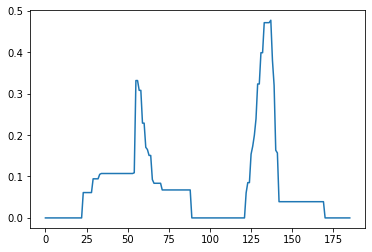

In [32]:
features_df.loc[
    idx["rwrist", 0, "drinking", [0]],
    idx["dynamic", "velocities", "minimum", "magnitude"]
].explode().reset_index(drop=True).plot()

ad esempio selezionare tutte le righe di una certa azione e calcolare corr di tutte le colonne rispetto a tutte le altre farlo divisa in gruppi di feature, ognuno un'azione

visualizzare il reacing rispetto al trasporto

test statistici

1.correlazione tra le feature della stessa azione(ci sono campioni di vari soggetti, si può guardare persona per persona)
-> formulazione di ipotesi da validare o meno nella seconda parte

2.test stat su azioni analoghe

3.ML: classificare i campioni (supervisionato): azione 1 vs azione 2

4: non supervisionato, clustering kmeans su coppie di azioni (bere e mangiare) con k=2, per visualizzare ridurre la dimensionalità con PCA con d=2 o 3

Su tutto o sulle 3 classi di feature separatamente


Ora possiamo calcolare le correlazioni delle ipotesi formulate nella prima parte:
* ipotesi 1 : azioni come bere e mangiare patatine sono simili, in particolare sappiamo che il braccio sinistro con compie quasi nessun movimento quindi la correlazione è più alta mentre, per il braccio destro che compie l'azione, per quanto il movimento sia simile, sarà meno correlato. Verifichiamo l'ipotesi in base alla velocità media del movimento

<AxesSubplot:>

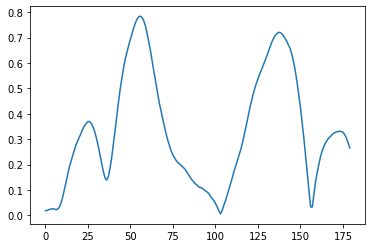

In [33]:
rd=features_df.loc[
    idx["rwrist", 0, "drinking", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:180]

rd.plot()

<AxesSubplot:>

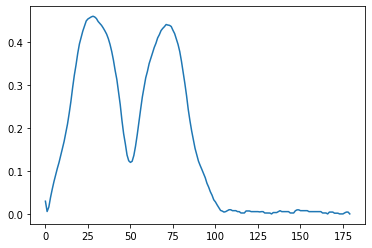

In [34]:
re=features_df.loc[
    idx["rwrist", 0, "eat_crisp", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:180]

re.plot()

In [35]:
np.corrcoef(rd.astype(float), re.astype(float))

array([[1.       , 0.0113011],
       [0.0113011, 1.       ]])

<AxesSubplot:>

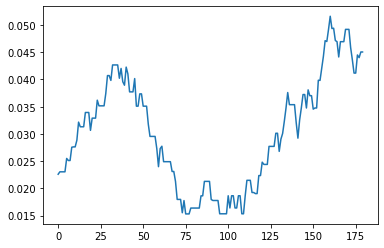

In [36]:
ld=features_df.loc[
    idx["lwrist", 0, "drinking", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:180]

ld.plot()

<AxesSubplot:>

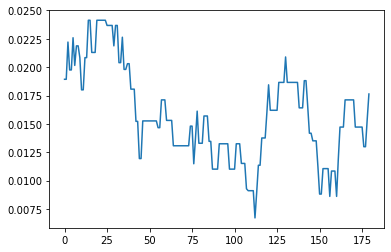

In [37]:
le=features_df.loc[
    idx["lwrist", 0, "eat_crisp", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:180]

le.plot()

In [38]:
np.corrcoef(ld.astype(float),le.astype(float))

array([[1.        , 0.25935081],
       [0.25935081, 1.        ]])

Dato che i movimenti del polso sinistro sono quasi impercettibili, rappresentandoli hanno molti scalini

* Ipotesi 2 : correlazione tra i giunti del viso nell'azione di bere

<AxesSubplot:>

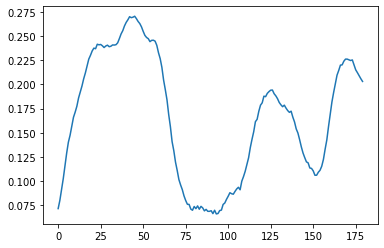

In [39]:
occhiodx=features_df.loc[
    idx["reye", 0, "drinking", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:180]

occhiodx.plot()

<AxesSubplot:>

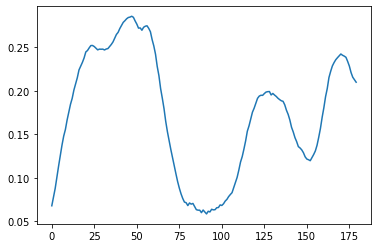

In [40]:
occhiosx=features_df.loc[
    idx["leye", 0, "drinking", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:180]

occhiosx.plot()

<AxesSubplot:>

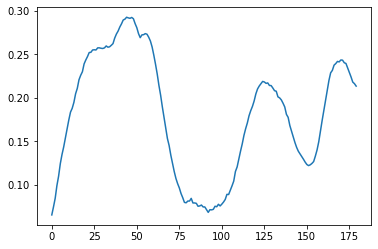

In [41]:
naso=features_df.loc[
    idx["nose", 0, "drinking", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:180]

naso.plot()

In [42]:
np.corrcoef(occhiodx.astype(float),occhiosx.astype(float))

array([[1.        , 0.99359146],
       [0.99359146, 1.        ]])

In [43]:
np.corrcoef(naso.astype(float),occhiodx.astype(float))

array([[1.        , 0.99380143],
       [0.99380143, 1.        ]])

In [44]:
np.corrcoef(naso.astype(float),occhiosx.astype(float))

array([[1.        , 0.99514411],
       [0.99514411, 1.        ]])

* Ipotesi 3: polso destro e sinistro fanno muovimenti correlati nell'azione sanitise

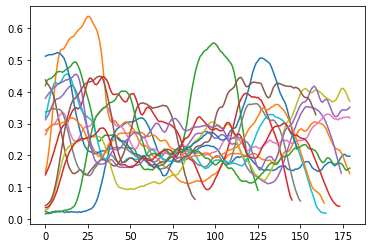

In [45]:
allrs = []

for i in range(0,16):
    allrs.append(features_df.loc[
        idx["rwrist", i, "sanitise", [0]],
        idx["dynamic", "velocities", "mean", "magnitude"]
    ].explode().reset_index(drop=True)[:180])


for i in range(0, len(allrs)):
    allrs[i].plot()




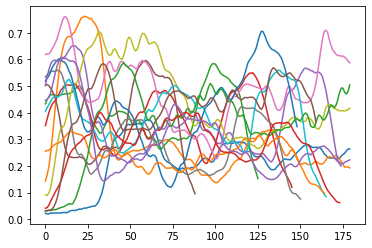

In [46]:
allls = []

for i in range(0,16):
    allls.append(features_df.loc[
    idx["lwrist", i, "sanitise", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
    ].explode().reset_index(drop=True)[:180])

for i in range(0, len(allls)):
    allls[i].plot()

    

In [47]:
corr = []
for i in range(0, len(allrs)-1):
    corr.append(np.corrcoef(allrs[i].astype(float),allls[i].astype(float)))
print(corr)

[array([[1.        , 0.91205237],
       [0.91205237, 1.        ]]), array([[1.        , 0.90571877],
       [0.90571877, 1.        ]]), array([[1.        , 0.90907241],
       [0.90907241, 1.        ]]), array([[1.        , 0.39965494],
       [0.39965494, 1.        ]]), array([[1.        , 0.91136249],
       [0.91136249, 1.        ]]), array([[1.        , 0.95590279],
       [0.95590279, 1.        ]]), array([[1.        , 0.68713602],
       [0.68713602, 1.        ]]), array([[1.        , 0.82930952],
       [0.82930952, 1.        ]]), array([[ 1.        , -0.21764212],
       [-0.21764212,  1.        ]]), array([[1.        , 0.67233871],
       [0.67233871, 1.        ]]), array([[1.       , 0.8841038],
       [0.8841038, 1.       ]]), array([[1.        , 0.80865976],
       [0.80865976, 1.        ]]), array([[1.        , 0.78629308],
       [0.78629308, 1.        ]]), array([[1.        , 0.78450658],
       [0.78450658, 1.        ]]), array([[1.       , 0.7086531],
       [0.708653

* Ipotesi 4 : correlazione tra le azioni di trasporto

<AxesSubplot:>

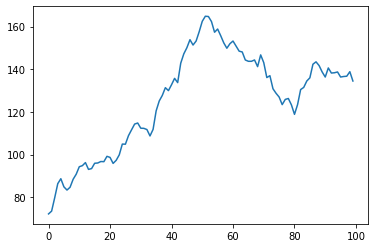

In [48]:
rtrc = features_df.loc[
    idx["rwrist", 0, "transport_rubiks_cube", [0]],
    idx["dynamic", "jerk", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtrc.plot()

<AxesSubplot:>

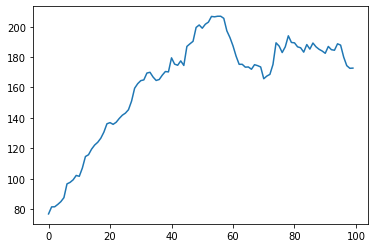

In [49]:
rtb = features_df.loc[
    idx["rwrist", 0, "transport_bottle", [0]],
        idx["dynamic", "jerk", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtb.plot()

<AxesSubplot:>

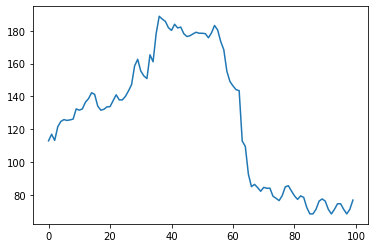

In [50]:
rtp = features_df.loc[
    idx["rwrist", 0, "transport_pen", [0]],
    idx["dynamic", "jerk", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtp.plot()

In [51]:
np.corrcoef(rtrc.astype(float),rtb.astype(float))

array([[1.        , 0.91369116],
       [0.91369116, 1.        ]])

In [52]:
np.corrcoef(rtrc.astype(float),rtp.astype(float))

array([[1.        , 0.04468691],
       [0.04468691, 1.        ]])

In [53]:
np.corrcoef(rtb.astype(float),rtp.astype(float))

array([[ 1.        , -0.01729528],
       [-0.01729528,  1.        ]])

<AxesSubplot:>

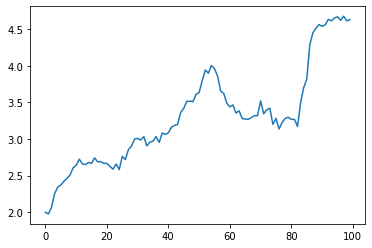

In [54]:
rtrc = features_df.loc[
    idx["rwrist", 0, "transport_rubiks_cube", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtrc.plot()

<AxesSubplot:>

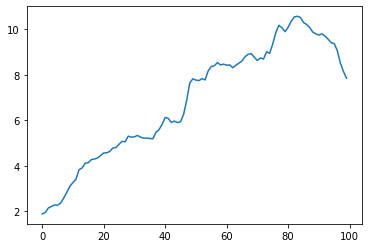

In [55]:
rtb = features_df.loc[
    idx["rwrist", 0, "transport_bottle", [0]],
        idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtb.plot()

<AxesSubplot:>

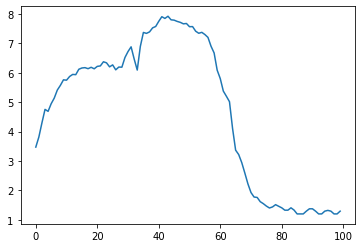

In [56]:
rtp = features_df.loc[
    idx["rwrist", 0, "transport_pen", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtp.plot()

In [57]:
np.corrcoef(rtrc.astype(float),rtb.astype(float))

array([[1.        , 0.78930221],
       [0.78930221, 1.        ]])

In [58]:
np.corrcoef(rtrc.astype(float),rtp.astype(float))

array([[ 1.        , -0.44319951],
       [-0.44319951,  1.        ]])

In [59]:
np.corrcoef(rtb.astype(float),rtp.astype(float))

array([[ 1.       , -0.5946043],
       [-0.5946043,  1.       ]])

* Ipotesi 5 : le stesse azioni compiute da ogni individuo con la stessa parte del corpo dovrebbe essere fortemente correlata, ad esempio se prendiamo l'azione di bere e il polso destro per ogni individuo ci dovrebbe essere un'alta correlazione


[array([[ 1.        , -0.95919921],
       [-0.95919921,  1.        ]]), array([[ 1.        , -0.15262823],
       [-0.15262823,  1.        ]]), array([[ 1.        , -0.06223747],
       [-0.06223747,  1.        ]]), array([[ 1.        , -0.19010863],
       [-0.19010863,  1.        ]]), array([[1.        , 0.88197153],
       [0.88197153, 1.        ]]), array([[1.        , 0.58105976],
       [0.58105976, 1.        ]]), array([[1.        , 0.58536975],
       [0.58536975, 1.        ]]), array([[1.       , 0.0891538],
       [0.0891538, 1.       ]]), array([[ 1.        , -0.38617012],
       [-0.38617012,  1.        ]]), array([[ 1.        , -0.62325196],
       [-0.62325196,  1.        ]]), array([[1.        , 0.73473294],
       [0.73473294, 1.        ]]), array([[ 1.        , -0.14840779],
       [-0.14840779,  1.        ]]), array([[ 1.       , -0.6566924],
       [-0.6566924,  1.       ]]), array([[ 1.        , -0.14529319],
       [-0.14529319,  1.        ]])]


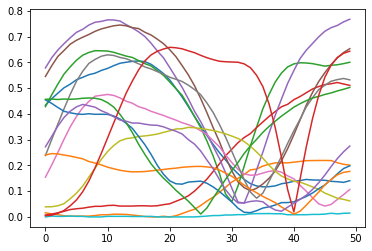

In [60]:
alldr = []

for i in range(0,15):
    alldr.append(features_df.loc[
        idx["rwrist", i, "touch_bottle", [0]],
        idx["displacement", "positions", "total_displacement", "magnitude"]
    ].explode().reset_index(drop=True)[:50])
#print(alldr)

for i in range(0, len(alldr)):
    alldr[i].plot()
    
corr = []
for i in range(0, len(alldr)-1):
    corr.append(np.corrcoef(alldr[i].astype(float), alldr[i+1].astype(float)))
print(corr)

[array([[1.        , 0.76974105],
       [0.76974105, 1.        ]]), array([[1.        , 0.51438792],
       [0.51438792, 1.        ]]), array([[ 1.        , -0.26170825],
       [-0.26170825,  1.        ]]), array([[ 1.        , -0.68582191],
       [-0.68582191,  1.        ]]), array([[ 1.        , -0.62701438],
       [-0.62701438,  1.        ]]), array([[1.        , 0.80921545],
       [0.80921545, 1.        ]]), array([[ 1.        , -0.41324158],
       [-0.41324158,  1.        ]]), array([[1.        , 0.26304347],
       [0.26304347, 1.        ]]), array([[ 1.        , -0.18313628],
       [-0.18313628,  1.        ]]), array([[1.        , 0.75684551],
       [0.75684551, 1.        ]]), array([[1.        , 0.83234398],
       [0.83234398, 1.        ]]), array([[1.        , 0.72649225],
       [0.72649225, 1.        ]]), array([[1.        , 0.88753862],
       [0.88753862, 1.        ]]), array([[1.        , 0.57431098],
       [0.57431098, 1.        ]])]


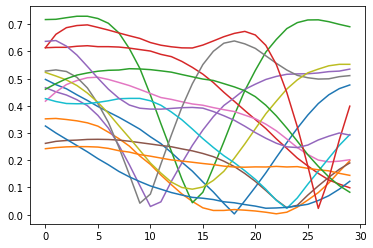

In [61]:
alldr = []

for i in range(0,15):
    alldr.append(features_df.loc[
        idx["rwrist", i, "touch_bottle", [1]],
        idx["displacement", "positions", "total_displacement", "magnitude"]
    ].explode().reset_index(drop=True)[:30])


for i in range(0, len(alldr)):
    alldr[i].plot()
    
corr = []
for i in range(0, len(alldr)-1):
    corr.append(np.corrcoef(alldr[i].astype(float), alldr[i+1].astype(float)))
print(corr)

<AxesSubplot:>

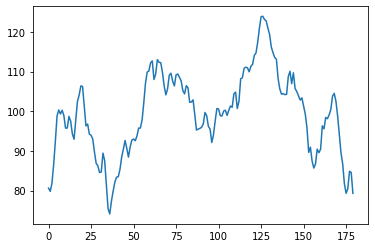

In [62]:
jm = features_df.loc[
    idx["rwrist", 0, "drinking", [0]],
    idx["dynamic", "jerk", "mean", "magnitude"]
].explode().reset_index(drop=True)[:180]

jm.plot()

<AxesSubplot:>

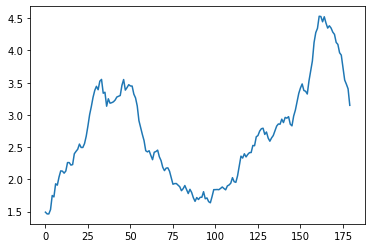

In [63]:
am = features_df.loc[
    idx["rwrist", 0, "drinking", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:180]

am.plot()

In [64]:
np.corrcoef(jm.astype(float),am.astype(float))

array([[ 1.        , -0.30297442],
       [-0.30297442,  1.        ]])

In [65]:
np.corrcoef(am.astype(float),jm.astype(float))

array([[ 1.        , -0.30297442],
       [-0.30297442,  1.        ]])

<AxesSubplot:>

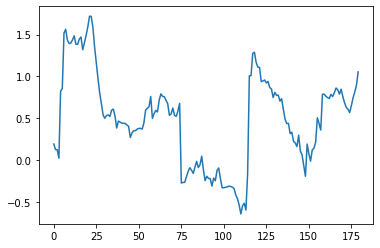

In [66]:
dask = features_df.loc[
    idx["rwrist", 0, "drinking", [0]],
    idx["dynamic", "acceleration", "skewness", "magnitude"]
].explode().reset_index(drop=True)[:180]

dask.plot()

<AxesSubplot:>

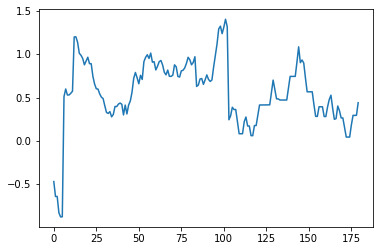

In [67]:
eask = features_df.loc[
    idx["rwrist", 0, "eat_crisp", [0]],
    idx["dynamic", "acceleration", "skewness", "magnitude"]
].explode().reset_index(drop=True)[:180]

eask.plot()

In [68]:
np.corrcoef(dask.astype(float), eask.astype(float))

array([[ 1.        , -0.03043803],
       [-0.03043803,  1.        ]])

<hr>

Ad esempio selezionare tutte le righe di una certa azione e calcolare corr di tutte le colonne rispetto a tutte le altre farlo divisa in gruppi di feature, ognuno un'azione

visualizzare il reacing rispetto al trasporto

test statistici

1.correlazione tra le feature della stessa azione(ci sono campioni di vari soggetti, si può guardare persona per persona)
-> formulazione di ipotesi da validare o meno nella seconda parte

2.test stat su azioni analoghe

3.ML: classificare i campioni (supervisionato): azione 1 vs azione 2

4: non supervisionato, clustering kmeans su coppie di azioni (bere e mangiare) con k=2, per visualizzare ridurre la dimensionalità con PCA con d=2 o 3

Su tutto o sulle 3 classi di feature separatamente

Creo un subdataset prendendo in considerazione l'azione di trasporto con il braccio destro

In [113]:
#result_df = features_df.loc[(features_df.index.get_level_values('joint') == "rwrist") & (features_df.index.get_level_values('person') == 0) & (features_df.index.get_level_values('action') == "transport_bottle") & (features_df.index.get_level_values('sample') == 0) & (features_df.columns.get_level_values('variable') == "magnitude")]
#print(result_df)


Calcolo la correlazione tra le varie feature

In [153]:
transport_df = features_df.loc[idx["rwrist", 0, "transport_pen", 0]].reset_index(drop=True)
corr = []
for a in transport_df:
    corr.append(a[:10])
corrs = np.corrcoef(corr)

print(corrs)




"""   
for i in range(transport_df.columns.nlevels-1):
    for j in range (0,len(transport_df.columns.get_level_values(i))):
        corr.append(np.corrcoef(transport_df.loc[transport_df.columns.get_level_values(i).unique()[j]].astype(float), transport_df.loc[transport_df.columns.get_level_values(i+1).unique()[j]].astype(float)))
print(corr)
"""

[[1.         0.79735797 0.48292578 ... 0.76116172 0.68184659 0.47616204]
 [0.79735797 1.         0.19874991 ... 0.70789399 0.8437139  0.66126169]
 [0.48292578 0.19874991 1.         ... 0.06608088 0.11019859 0.09505477]
 ...
 [0.76116172 0.70789399 0.06608088 ... 1.         0.82620653 0.61848288]
 [0.68184659 0.8437139  0.11019859 ... 0.82620653 1.         0.91851117]
 [0.47616204 0.66126169 0.09505477 ... 0.61848288 0.91851117 1.        ]]


'   \nfor i in range(transport_df.columns.nlevels-1):\n    for j in range (0,len(transport_df.columns.get_level_values(i))):\n        corr.append(np.corrcoef(transport_df.loc[transport_df.columns.get_level_values(i).unique()[j]].astype(float), transport_df.loc[transport_df.columns.get_level_values(i+1).unique()[j]].astype(float)))\nprint(corr)\n'

In [ ]:
#np.corrcoef(dask.astype(float), eask.astype(float))

#for date,new_df in result_df.groupby(level=0):
#    print(new_df)

#result_df.corr